# Part 02: Fine-tuning Prithvi model using Thailand dataset

## What is Fine-tuning?

According to [IBM](https://www.ibm.com/topics/fine-tuning) *"Fine-tuning in machine learning is the process of adapting a pre-trained model for specific tasks or use cases. It has become a fundamental deep learning technique, particularly in the training process of foundation models used for generative AI."*

For our specific case, the IBM-NASA Prithvi model was trained on the Continental United States data. For it to be usable on different regions (e.g. South East Asia). The model has to be fine-tuned using datasets from the region of interest.

## Fine-tuning

#### Before starting

1. When using this Notebook, make sure to use a server with GPU
2. Make sure as well, that you are using an environment with all the Prithvi prerequisites in place (please check jupyter notebook *00_intro_installation_prithvi.ipynb* as reference)
3. The GPU memory required to run the fine-tuning depends on multiple factors, but the main factors are:
    - how fast you want the fine-tuning to be completed?
    - how large is the dataset you are using?

#### Additional Notes

Multiple exploratory experiments were conducted to understand the various aspects and performance of the Prithvi model, the important findings / generalizations from those experiments are listed in this section.

Prithvi is flexible enough to handle multiple classes (5 to 15), however, the quality of the model is highly dependent on two factors:

1. **Balanced Proportion of Classses**
The model performs best if the proportion or % share of the classes are balanced. It doesn't have to be perfectly equal, but it is important that NO ONE CLASS IS OVERWHELMING OTHER CLASSES. An example of an ideal distribution is shown in the table below:
    
| lu class | % share |
|--------------|-------|
| urban | 15 % |
| agricultural | 25 % |
| forest | 20 % |
| water | 10 % |
| oil palm | 15 % |
| para rubber | 15 %|
| TOTAL | 100 % |
        
2. **Quality of the Training Data**
In some cases, the training data itself is not 100% correct. This caused confusion in the model, thus lowering performance in some of the previous experiments.

A key example, is in Bangkok (LU image below). The lower-left section where there is a huge gap in the pixels, is due to that section being classified as Agricultural but with the level 2 classification of Aquaculture. This added confusion to the model and thus was removed from the Land Use map.

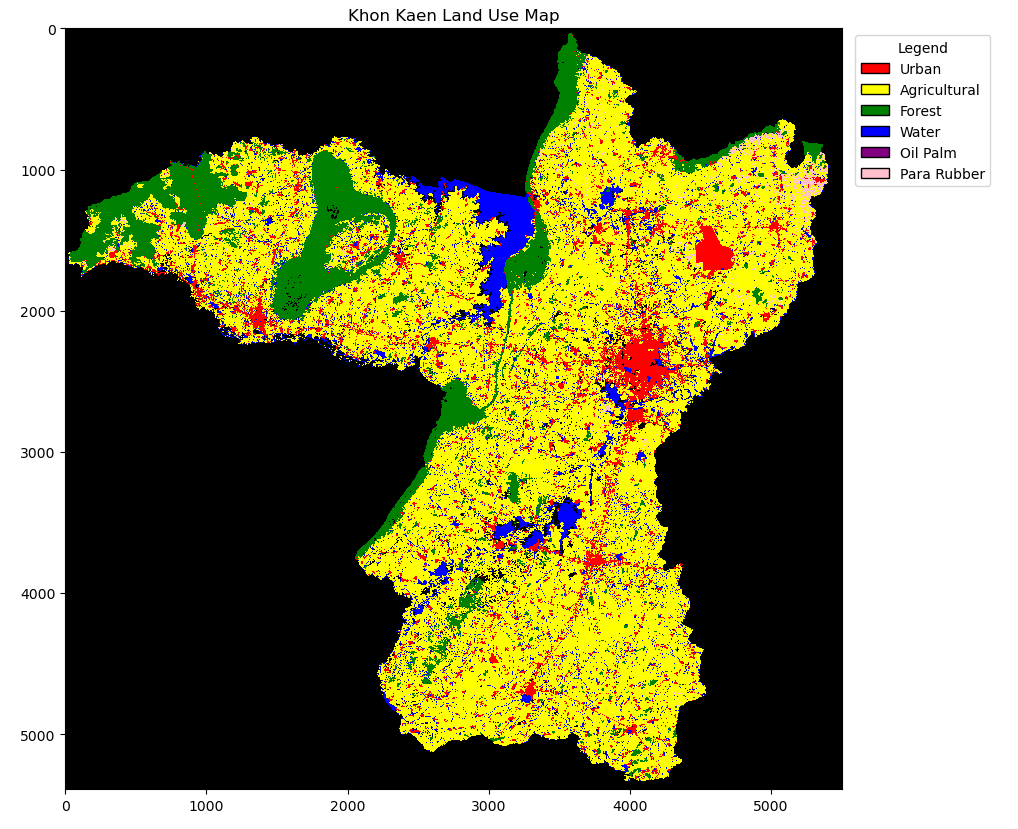

#### MMSeg
In this notebook, we finetune the Prithvi model using the MMSegmentation extension that the IBM-NASA team opensourced.

This is much easier to implement:
- No model surgery required
- No need to write boilerplate training code
- Integrations with Tensorboard, MLFlow, ...
- Segmentation evaluation metrics / losses built in

1. Build your config file, check [MMSeg](https://mmsegmentation.readthedocs.io/en/0.x/tutorials/config.html) for more general tutorials. For this use case, please check `finetuning_config.py` in the scripts folder.
2. Collect your dataset in the format determined by MMSeg
3. Run `mim train mmsegmentation <path to my config>` in the terminal.

#### IMPORTANT:
The cell block below loads the `finetuning_config.py` file. This is just to show how the file looks inside and what parameters are modifiable for the finetuning.

`%load finetuning_config.py` --> use this command to load the config file into a cell

`%%writefile finetuning_config.py` --> use this command to save your edits / overwrite the config file

#### Parameters

The table below shows the parameters that can be modified to adjust the performance of the finetuning.

| Parameter | Description | Experiment Options |
|-----------|------------------------|----------------|
| num_layers | Controls the depth of the model. | If the model finetuning is overfitting, considering decreasing to 4 |
| patch_size | Controls the size of the patch images, smaller patches give model finer detail but might increase memory consumption. | Consider tests reducing patch_size to 8
| embed_dim | Defines the size of each patch embeddings vector, the higher the value, the richer the representations but also increases model size and memory consumption. | 
| num_heads | Controls the number of attention heads improves the model’s ability to focus on different parts of the input, enhancing representational power. Increasing model heads can help improve to capture spatial relationships. (embed_dim should be divisible by num_heads). | Test increasing to 12 or 16 |
| tubelet_size | Defines how many frames are grouped in the model (useful for video data) |
| max_epochs | Total number of training cycles over the dataset. |

#### Finetuning config.py

In [157]:
%%writefile finetuning_config_spot.py

import os, rasterio

experiment = 'exp01' #"<experiment name>"
data_root = 'Khon-kaen/final_training_data' #<path to data root>
project_dir = 'spotb_training_22' #"<project directory name>"
work_dir = os.path.join(project_dir, experiment)
save_path = work_dir
img_stack = 'Khon-kaen/stack.tif'

dist_params = dict(backend="nccl")
log_level = "INFO"
load_from = None
resume_from = None
cudnn_benchmark = True
custom_imports = dict(imports=["geospatial_fm"])
# import geofm
num_frames = 3
img_size = 224 #size of the patch images used in training (224x224)
num_workers = 1 #original is 4, this is an overall parameter used to define the 


### MODEL PARAMETERS TO BE DEFINED BY USER
pretrained_weights_path = "/prithvi/Prithvi_100M.pt" #"<path to pretrained weights>"
num_layers = 12
patch_size = 16 #original is 16
embed_dim = 768
num_heads = 12
tubelet_size = 1
max_epochs = 100
eval_epoch_interval = 1


loss_weights_multi = [ #0.0,
                      1.0,
                      1.0,
                      1.5,
                      1.5,
                      1.5,
                      4.0]
# Define the land-use or land-cover classes 
CLASSES = (
            'NAN', #NAN
            "URB", #urban
            "AGR", #agricultural
            "FOR", #forest
            "WTR", #water
            "OIL", #oil palm
            "PRB") #para rubber


loss_func = dict(
    type="FocalLoss",
    gamma=2.0,  # Focuses more on difficult-to-learn classes like PRB
    alpha=loss_weights_multi,  # Still keeps class weight balancing
#    type="CrossEntropyLoss",
#    use_sigmoid=False,
#    class_weight=loss_weights_multi,
#    avg_non_ignore=True,
)

output_embed_dim = embed_dim * num_frames



dataset_type = "GeospatialDataset"

## The 18 values for 'means and stds lists' are specific for Thailand, these can be modified if the model is applied to a different region.


img_norm_cfg = dict(
    means=rasterio.open(img_stack).read().mean(axis=(1,2)).tolist(),
    stds=rasterio.open(img_stack).read().std(axis=(1,2)).tolist(),
)
          
bands = [1, 2, 3, 4, 5, 6]

tile_size = 224
orig_nsize = 512
crop_size = (tile_size, tile_size)
train_pipeline = [
    dict(type="LoadGeospatialImageFromFile", to_float32=True),
    dict(type="LoadGeospatialAnnotations", reduce_zero_label=True),
    dict(type="RandomFlip",  prob=0.5),
    dict(type="RandomRotate", prob=0.5, degree=10),
    #dict(type="Resize", img_scale=(512, 512), ratio_range=(0.8, 1.2)),
    #dict(type="RandomCrop", crop_size=crop_size, cat_max_ratio=0.75),
    dict(type="ToTensor", keys=["img", "gt_semantic_seg"]),
    # to channels first
    dict(type="TorchPermute", keys=["img"], order=(2, 0, 1)),
    dict(type="TorchNormalize", **img_norm_cfg),
    dict(type="TorchRandomCrop", crop_size=crop_size),
    dict(
        type="Reshape",
        keys=["img"],
        new_shape=(len(bands), num_frames, tile_size, tile_size),
    ),
    dict(type="Reshape", keys=["gt_semantic_seg"], new_shape=(1, tile_size, tile_size)),
    dict(type="CastTensor", keys=["gt_semantic_seg"], new_type="torch.LongTensor"),
    dict(type="Collect", keys=["img", "gt_semantic_seg"]),
]

test_pipeline = [
    dict(type="LoadGeospatialImageFromFile", to_float32=True),
    dict(type="ToTensor", keys=["img"]),
    # to channels first
    dict(type="TorchPermute", keys=["img"], order=(2, 0, 1)),
    dict(type="TorchNormalize", **img_norm_cfg),
    dict(
        type="Reshape",
        keys=["img"],
        new_shape=(len(bands), num_frames, -1, -1),
        look_up=dict({"2": 1, "3": 2}),
    ),
    dict(type="CastTensor", keys=["img"], new_type="torch.FloatTensor"),
    dict(
        type="CollectTestList",
        keys=["img"],
        meta_keys=[
            "img_info",
            "seg_fields",
            "img_prefix",
            "seg_prefix",
            "filename",
            "ori_filename",
            "img",
            "img_shape",
            "ori_shape",
            "pad_shape",
            "scale_factor",
            "img_norm_cfg",
        ],
    ),
]


dataset = "GeospatialDataset"
data = dict(
    samples_per_gpu=1, #original is 8, decrease this parameter if the memory consumption is too much
    workers_per_gpu=1, #original is 2, decrease this parameter if the memory consumption is too much
    train=dict(
        type=dataset,
        CLASSES=CLASSES,
        reduce_zero_label=True,
        data_root=data_root,
        img_dir='train/images',
        ann_dir='train/masks',
        pipeline=train_pipeline,
        img_suffix=".tif",
        seg_map_suffix=".tif",
    ),
    val=dict(
        type=dataset,
        CLASSES=CLASSES,
        reduce_zero_label=True,
        data_root=data_root,
        img_dir='val/images',
        ann_dir='val/masks',
        pipeline=test_pipeline,
        img_suffix=".tif",
        seg_map_suffix=".tif",
    ),
    test=dict(
        type=dataset,
        CLASSES=CLASSES,
        reduce_zero_label=True,
        data_root=data_root,
        img_dir='test/images',
        ann_dir='test/masks',
        pipeline=test_pipeline,
        img_suffix=".tif",
        seg_map_suffix=".tif",
    ),
)

optimizer = dict(type="AdamW", lr=5e-06, betas=(0.9, 0.999), weight_decay=0.05)
optimizer_config = dict(grad_clip=None)
lr_config = dict(
    policy="poly",
    warmup="linear",
    warmup_iters=500,
    warmup_ratio=1e-06,
    power=1.0,
    min_lr=0.0,
    by_epoch=False,
)

log_config = dict(
    interval=10, hooks=[dict(type="TextLoggerHook"), dict(type="TensorboardLoggerHook")]
)

checkpoint_config = dict(by_epoch=True, interval=5, out_dir=save_path)

evaluation = dict(
    interval=eval_epoch_interval,
    metric="mIoU",
    pre_eval=True,
    save_best="mIoU",
    by_epoch=True,
)
reduce_train_set = dict(reduce_train_set=False)
reduce_factor = dict(reduce_factor=1)
runner = dict(type="EpochBasedRunner", max_epochs=max_epochs)
workflow = [("train", 1)]
norm_cfg = dict(type="BN", requires_grad=True)

model = dict(
    type="TemporalEncoderDecoder",
    frozen_backbone=False,
    backbone=dict(
        type="TemporalViTEncoder",
        pretrained=pretrained_weights_path,
        img_size=img_size,
        patch_size=patch_size,
        num_frames=num_frames,
        tubelet_size=1,
        in_chans=len(bands),
        embed_dim=embed_dim,
        depth=6,
        num_heads=num_heads,
        mlp_ratio=4.0,
        norm_pix_loss=False,
    ),
    neck=dict(
        type="ConvTransformerTokensToEmbeddingNeck",
        embed_dim=embed_dim * num_frames,
        output_embed_dim=output_embed_dim,
        drop_cls_token=True,
        Hp=14,
        Wp=14,
    ),
    decode_head=dict(
        num_classes=6, #len(CLASSES),
        in_channels=output_embed_dim,
        type="FCNHead",
        in_index=-1,
        channels=256,
        num_convs=1,
        concat_input=False,
        dropout_ratio=0.1,
        norm_cfg=dict(type="BN", requires_grad=True),
        align_corners=False,
        #ignore_index=0, # to remove pixels with 0 values due to LU Gaps
        loss_decode=loss_func,
    ),
    auxiliary_head=dict(
        num_classes=6, # len(CLASSES),
        in_channels=output_embed_dim,
        type="FCNHead",
        in_index=-1,
        channels=256,
        num_convs=2,
        concat_input=False,
        dropout_ratio=0.1,
        norm_cfg=dict(type="BN", requires_grad=True),
        align_corners=False,
        #ignore_index=0, # to remove pixels with 0 values due to LU Gaps
        loss_decode=loss_func,
    ),
    train_cfg=dict(),
    test_cfg=dict(
        mode="slide",
        stride=(int(tile_size / 2), int(tile_size / 2)),
        crop_size=(tile_size, tile_size),
    ),
)

auto_resume = False

Overwriting finetuning_config_spot.py


In [158]:
## this cell runs the finetuning_config.py python file
!mim train mmsegmentation finetuning_config_spot.py

41408.62s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


Training command is /opt/conda/bin/python3.10 /opt/conda/lib/python3.10/site-packages/mmseg/.mim/tools/train.py finetuning_config_spot.py --launcher none --gpus 1. 
/opt/conda/lib/python3.10/site-packages/mmseg/.mim/tools/train.py:136: UserWarning: `--gpus` is deprecated because we only support single GPU mode in non-distributed training. Use `gpus=1` now.
  warnings.warn('`--gpus` is deprecated because we only support '
2025-01-21 00:16:01,606 - mmseg - INFO - Multi-processing start method is `None`
2025-01-21 00:16:01,608 - mmseg - INFO - OpenCV num_threads is `8
2025-01-21 00:16:01,638 - mmseg - INFO - Environment info:
------------------------------------------------------------
sys.platform: linux
Python: 3.10.11 | packaged by conda-forge | (main, May 10 2023, 18:58:44) [GCC 11.3.0]
CUDA available: True
GPU 0: NVIDIA GeForce GTX 1080
CUDA_HOME: /usr
NVCC: Cuda compilation tools, release 11.5, V11.5.119
GCC: gcc (Ubuntu 11.3.0-1ubuntu1~22.04.1) 11.3.0
PyTorch: 1.11.0+cu115
PyTorch 